# Import Packages

In [1]:
from packages import *
%matplotlib inline

# Read Dataset

In [2]:
neg_files = glob.glob('virufy/segmented/neg/*')
pos_files = glob.glob('virufy/segmented/pos/*')
all_files = neg_files+pos_files
print(len(all_files))

121


In [3]:
l1, l2 = [], []
for i in all_files:
    l1.append(i)
    label = i.split('\\')[0][-3:].strip()
    l2.append(label)
df = pd.DataFrame(zip(l1,l2),columns=['fname','label'])
df.head()

,fname,label
0,virufy/segmented/neg\neg-0421-083-cough-m-53-0...,neg
1,virufy/segmented/neg\neg-0421-083-cough-m-53-1...,neg
2,virufy/segmented/neg\neg-0421-083-cough-m-53-1...,neg
3,virufy/segmented/neg\neg-0421-083-cough-m-53-1...,neg
4,virufy/segmented/neg\neg-0421-083-cough-m-53-1...,neg


# Get class distribution

In [4]:
df.set_index('fname', inplace=True)

for f in df.index:
    signal,rate = librosa.load(f)
    df.at[f, 'length'] = signal.shape[0]/rate
    
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
df.reset_index(inplace=True)

# Preprocessing

In [5]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, 
                         sharey=True, figsize=(20, 5))
    fig.suptitle('Time Series', size=16, y=1.02)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(signals.keys())[i])
            axes[y].plot(list(signals.values())[i])
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i+=1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, 
                         sharey=True, figsize=(20, 5))
    fig.suptitle('Fourier Transforms', size=16, y=1.02)
    i = 0
    for x in range(1):
        for y in range(2):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[y].set_title(list(fft.keys())[i])
            axes[y].plot(freq, Y)
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i+=1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, 
                         sharey=True, figsize=(20, 5))
    fig.suptitle('Mel Cepstrum Coefficients', size=16, y=1.02)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(mfccs.keys())[i])
            axes[y].imshow(list(mfccs.values())[i],
                        cmap='hot', interpolation='nearest')
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i+=1

def plot_fbank(fbanks):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, 
                         sharey=True, figsize=(20, 5))
    fig.suptitle('Filter Bank Coefficients', size=16, y=1.02)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(fbanks.keys())[i])
            axes[y].imshow(list(fbanks.values())[i],
                        cmap='hot', interpolation='nearest')
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i+=1

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [6]:
# Signal envelope to remove noise/silence
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

virufy/segmented/neg\neg-0421-083-cough-m-53-0.mp3
virufy/segmented/pos\pos-0421-084-cough-m-50-0.mp3


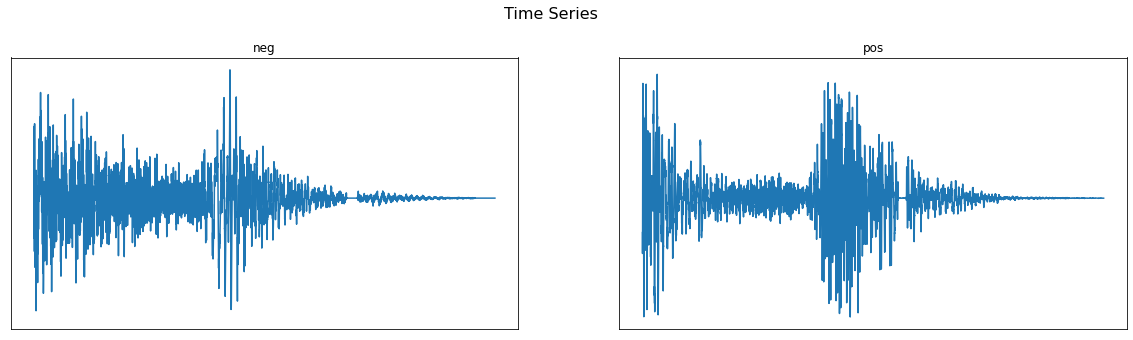

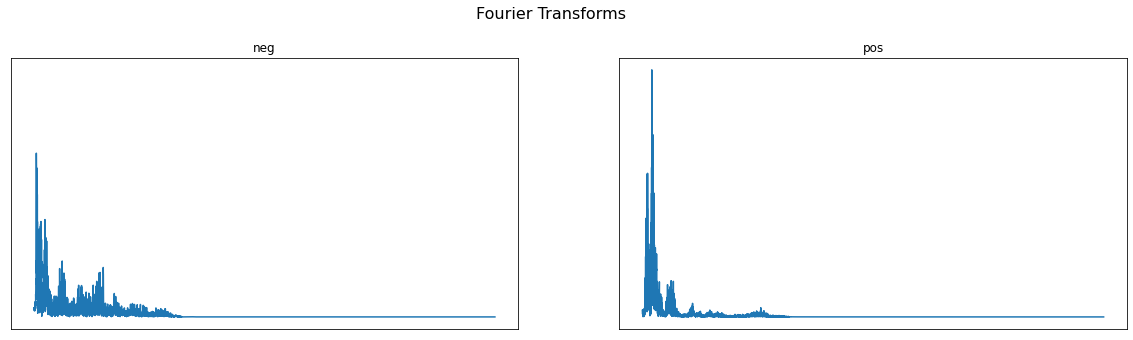

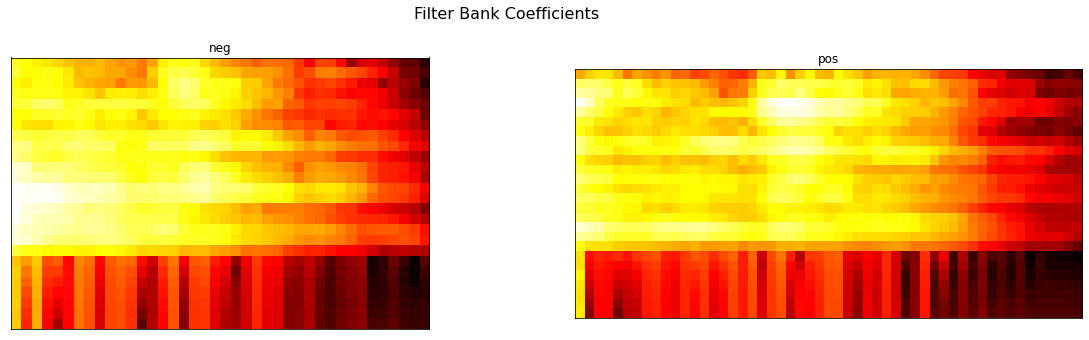

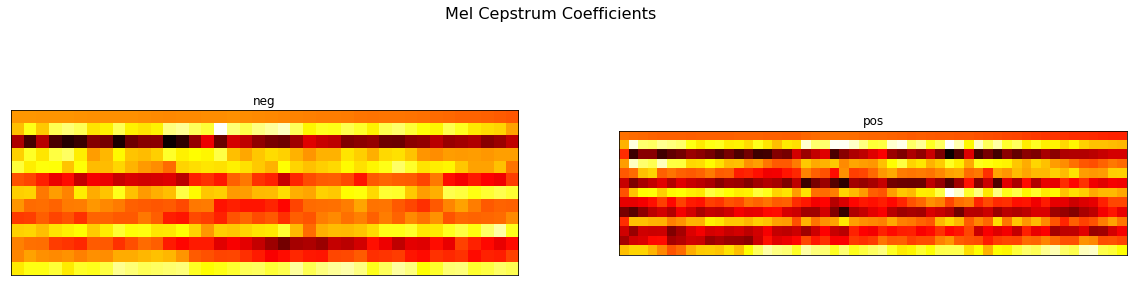

In [7]:
signals = {}
fft = {}
mfccs = {}
fbank = {}

for c in classes:
    wav_file = df[df.label==c].iloc[0,0]
    print(wav_file)
    signal,rate = librosa.load(wav_file,sr=48000)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
        
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1200).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], samplerate=rate, numcep=13, nfilt=26, nfft=1200).T
    mfccs[c] = mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [9]:
if len(os.listdir('virufy_clean')) == 0:
    for f in tqdm(df.fname):
        signal,rate = librosa.load(f,sr=16000)
        mask = envelope(signal, rate, 0.0005)
        f = f.split('\\')[1]
        wavfile.write('virufy_clean/'+f[:-3]+'wav', rate, signal[mask])

100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:19<00:00,  6.12it/s]
